In [6]:
#| hide
from diffusion_curvature.datasets import *
from diffusion_curvature.kernels import *
from diffusion_curvature.utils import plot_3d
from nbdev import show_doc
%load_ext autoreload
%autoreload 2

# Diffusion Curvature

> Fast, pointwise graph curvature

Diffusion Curvature is a pointwise extension of Ollivier-Ricci curvature, designed specifically for the often messy world of pointcloud data.
Its advantages include:

1. Unaffected by density fluctuations in data: it inherits the diffusion operator's denoising properties.
2. Fast, and scalable to millions of points: it depends only on matrix powering - no optimal transport required.

# Installation

The chief dependency is JAX, which provides a GPU-accelerated version of numpy we use for calculating diffusion scales quickly. Visit [JAX's Installation Site](https://jax.readthedocs.io/en/latest/installation.html) for instructions on installing it with support for your GPU (CUDA, TPU, AMD, or even Apple MPS). If you don't have a GPU, just run `conda/pip install jax`.

Then you can install diffusion curvature via

```sh
pip install git+https://github.com/professorwug/diffusion-curvature.git
```

We plan to provide pip and conda packages after publication.


## Usage

Suppose you have some pointcloud, $X$, and wish to find the curvature of each point. 

In [69]:
X, ks = torus(use_guide_points=True)

Diffusion Curvature uses the scikit-learn style `fit_transform` syntax, with only two needed inputs.

1. An input pointcloud $X$
2. A locality scale $l$, from 0 to 1

So, first import and instantiate the `DiffusionCurvature`, then call `fit_transform` with your data.

In [40]:
from diffusion_curvature.core import DiffusionCurvature


DC = DiffusionCurvature(
    estimate_local_dimension = False, 
)

curvatures = DC.fit_transform(
    X = X,
    locality_scale = 1,
)

Estimated dimension(s) in point cloud: {2}


What glorious geometric features!

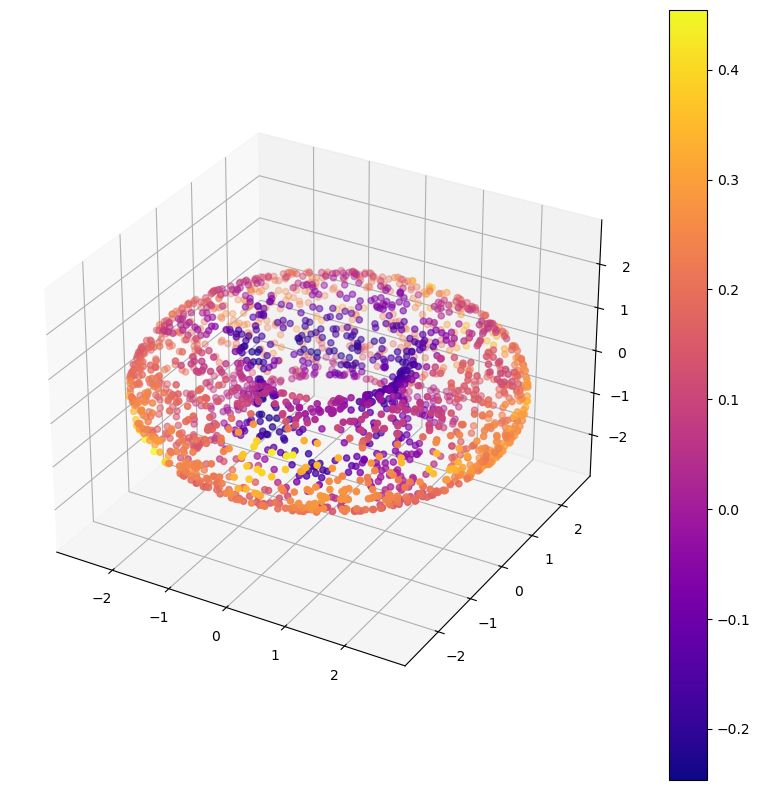

In [ ]:
plot_3d(X, curvatures)

As you see, `DC` has correctly estimated the intrinsic dimension of our torus as 2. By default the parameter `estimate_local_dimension` is true, and `DC` will perform this estimation locally for each point -- which is helpful if your pointcloud may contain many intersecting manifolds, like single-cell data.

We can play with the `locality_scale` to see what curvature looks like at different levels of locality.

Estimated dimension(s) in point cloud: {2}


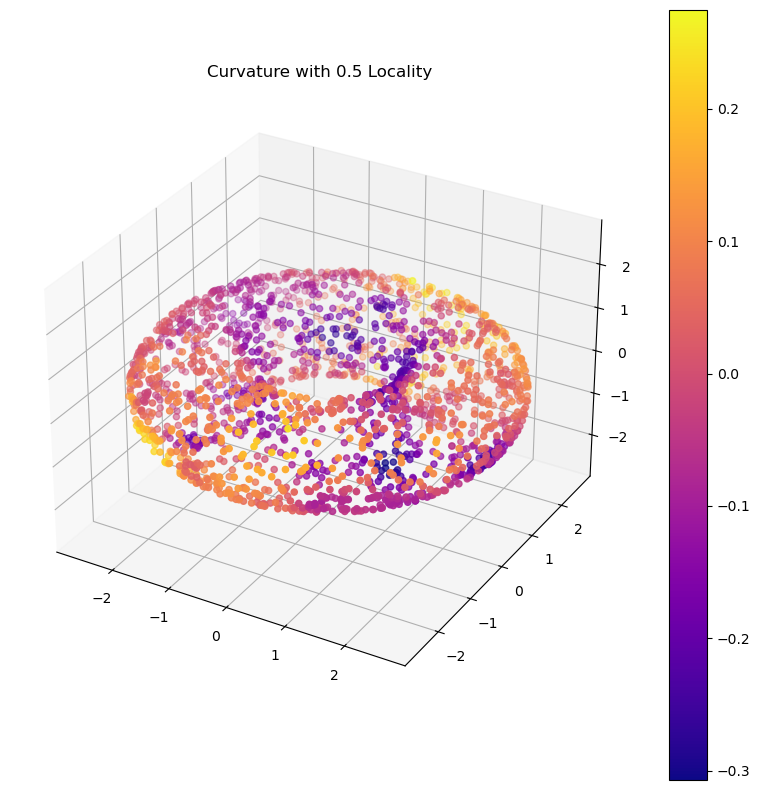

In [48]:
curvatures_low_locality = DC.fit_transform(
    X = X,
    locality_scale = 0.5,
)
plot_3d(X, curvatures_low_locality, title = "Curvature with 0.5 Locality")

Estimated dimension(s) in point cloud: {2}


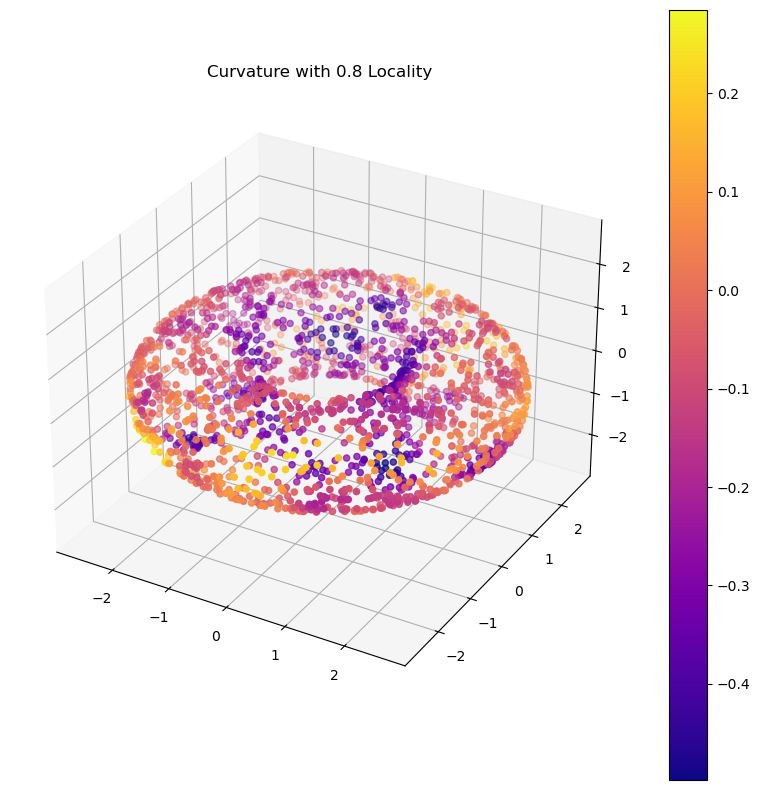

In [50]:
curvatures_medium_locality = DC.fit_transform(
    X = X,
    locality_scale = 0.8,
)
plot_3d(X, curvatures_medium_locality, title = "Curvature with 0.8 Locality")

You'll note that at smaller `locality_scales`, density starts to affect the curvature. We find that using 0.9 or 1 works for most data we've tried - but we recommend trying a few values to get a feel of how the curvature changes as one gets a broader picture of the manifold.

## Graph building

Diffusion Curvature will, by default, construct its own graph from pointcloud data using a bespoke *curvature-agnostic kernel* You can tailor the size of that kernel by supplying a `graph_knn` value.

Note that, unlike the tradition k-nearest neighbor kernel, this specifies the *total* number of points with non-negligable connection with the present point. 5-10 is usually too small.

Estimated dimension(s) in point cloud: {2}


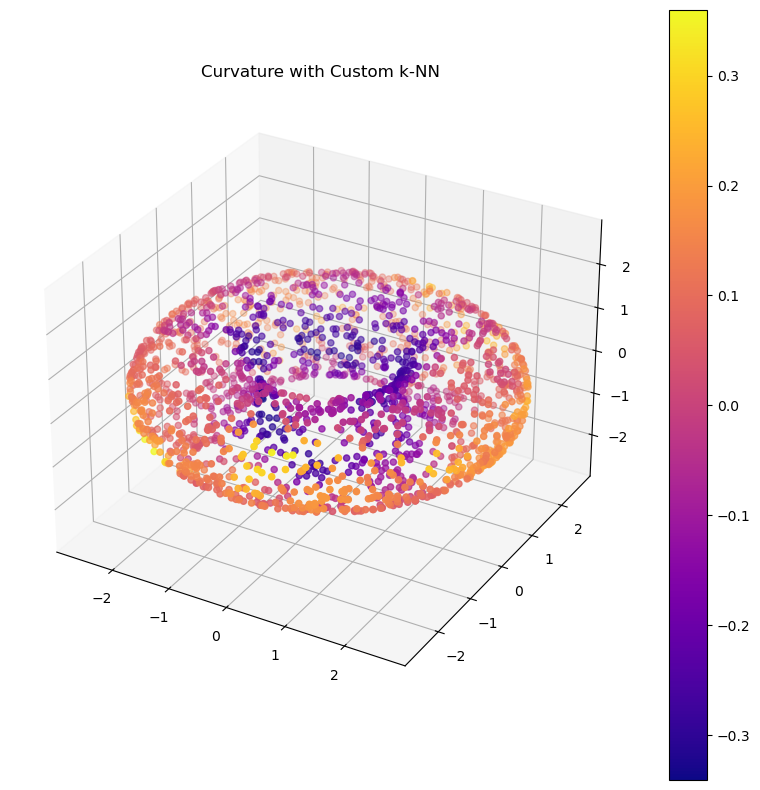

In [52]:
curvatures_custom_knn = DC.fit_transform(
    X = X,
    locality_scale = 1,
    graph_knn = 38,
)
plot_3d(X, curvatures_custom_knn, title = "Curvature with Custom k-NN")

If you want more control over the kernel used to construct a graph affinity matrix, you can define your own and supply it via the `graph_former` function. We supply a number of common kernels you can easily adapt.

2024-08-10 12:41:54,091:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-08-10 12:41:56,458:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-08-10 12:41:57,351:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-08-10 12:41:58,233:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


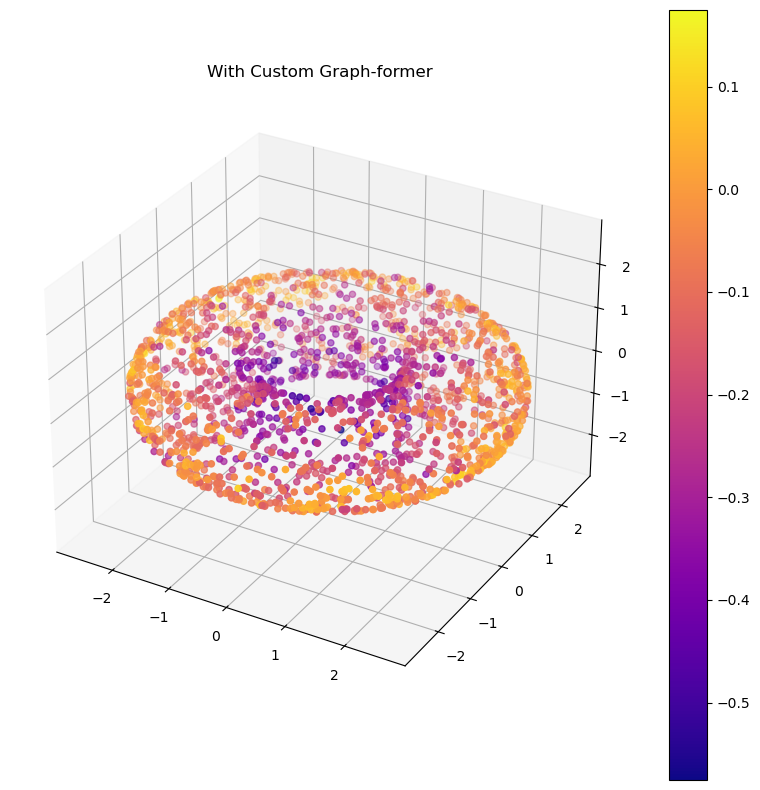

In [57]:
from diffusion_curvature.kernels import get_adaptive_graph, get_fixed_graph
from functools import partial

DC_with_custom_kernel = DiffusionCurvature(
    graph_former = partial(get_adaptive_graph, k = 10)
)
curvature_with_custom_kernel = DC_with_custom_kernel.fit_transform(X, dim = 2)
plot_3d(X, curvature_with_custom_kernel, title = "With Custom Graph-former")

You'll notice that the scale of curvature varies somewhat between kernels. We find that common kernels (particularly the adaptive kernel) actually disguise data geometry, and for this reason recommend using our curvature-agnostic kernel.

## Curvature Curves

Under the hood, Diffusion Curvature performs many scales of graph diffusion on (1) the given pointcloud, and (2) a set of comparison samples from Euclidean space of the given dimension. It then measures the 'Diffusion Energy' of those scales, and by comparing the energy of the given manifold to the comparison space, produces a curvature. 

We can visualize this comparison with a set of curves:

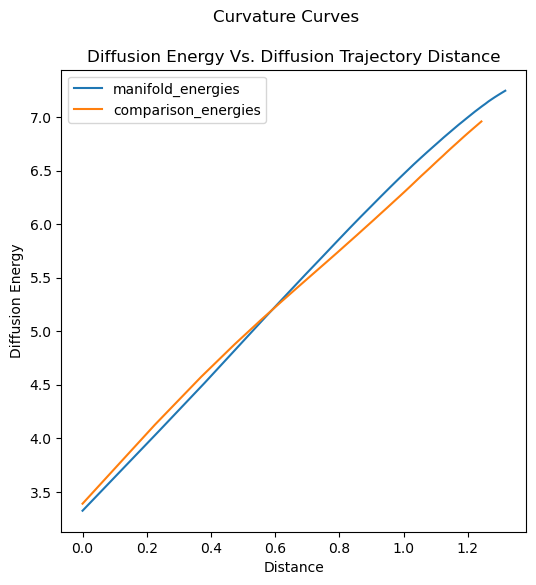

In [74]:
from diffusion_curvature.diffusion_laziness import curvature_curves
DC = DiffusionCurvature()
curvatures = DC.fit_transform(X, dim = 2, locality_scale=1)
manifold_energies = DC.manifold_lazy_est
comparison_energies = DC.comparison_lazy_est
curvature_curves(
    manifold_energies, comparison_energies, also_plot_against_time=False, 
    idx=1
    )

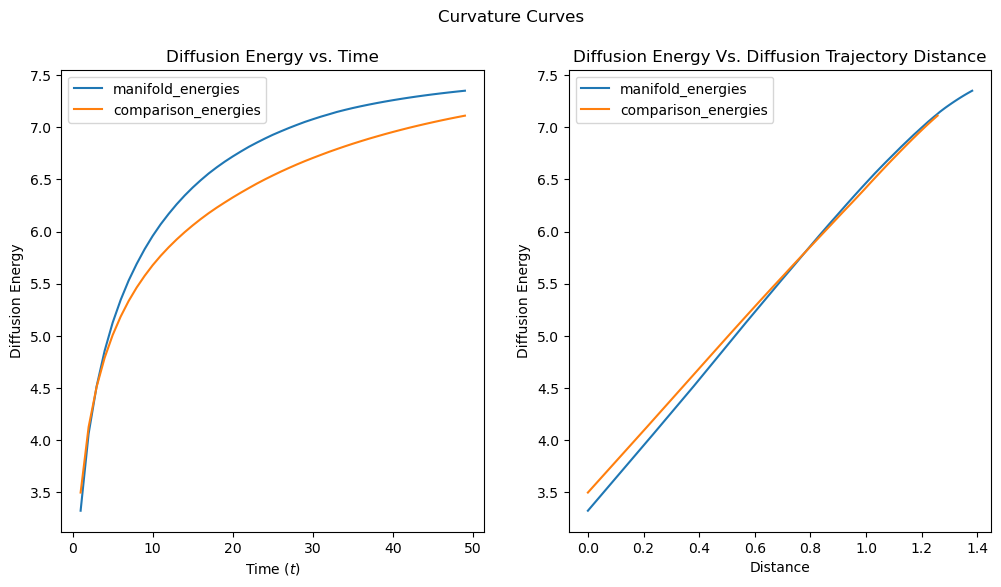

In [103]:
from diffusion_curvature.diffusion_laziness import curvature_curves
DC = DiffusionCurvature(smoothing = 2)
curvatures = DC.fit_transform(X, dim = 2, locality_scale=0.9, ts = list(range(1,50)),graph_knn = 150)
manifold_energies = DC.manifold_lazy_est
comparison_energies = DC.comparison_lazy_est
curvature_curves(
    manifold_energies, comparison_energies, also_plot_against_time=True, 
    idx=1
    )

Index 1 on the torus is in the negatively curved 'donut hole'. Here we see that, for later scales, the energy of diffusion in this donut hole is greater than on the plane. 
Notably, the same is not true for lower distances. 

The parameter `locality_scale` selects the fraction of the maximum distance you wish to use. `1` corresponds to the largest possible (around 1.2 here), while `0.5` gets $1.2 \times 0.5 = 0.6$.

## Development Installation

This project is packaged with [Pixi](https://pixi.sh), a modern Poetry-like package manager from the makers of Mamba that supports both pip and conda packages. To install the dependencies and get the project running, follow these steps:

1. Install [Pixi](https://pixi.sh) with `brew install pixi` or (for the brave) `curl -fsSL https://pixi.sh/install.sh | bash`.
2. Run `pixi install` in the project root. This installs both the dependencies and the `diffusion_curvature` package itself.
3. Run `pixi run postinstall` to install a jupyter kernel and nbdev's git hooks (which erase troublesome notebook metadata to prevent git conflicts)

To access Pixi's virtual environment, run `pixi shell` in the project root, or (if you have a python script), run `pixi run python my_script.py`. 